In [112]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
import cv2
from random import random, randint
from sklearn.decomposition import PCA
import os
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [30]:
def similarity(img, template):
    """
    returns the best fit template on the image
    """
    return cv2.matchTemplate(img, template, cv2.TM_CCORR_NORMED)

In [31]:
def process_similarity_map(simi_map, err_threshold):
    _min, _max = np.min(simi_map), np.max(simi_map)
    
    """
    p_choices -> The indices in SIMI_MAP whose values are below the threshold.
    """
    p_choices = np.where(simi_map >= _min + (1.0 - err_threshold) * (_max - _min))
    
    if len(p_choices[0]) == 0:
        return [np.unravel_index(np.argmax(simi_map), simi_map.shape)]
    
    """
    returns only the indices in SIMI_MAP whose values are below the threshold.
    """
    return zip(*p_choices)

In [32]:
def select_patch_synthesis(img, img_out, pos_y, pos_x, patch_height, patch_width,
                           overlap_height, overlap_width, err_threshold):
    """
    Finds a patch from original image to be placed in final image
    """
    
    """
    Directly returns the random position of the original image
    as there is nothing compare with.
    """
    if (pos_y, pos_x) == (0, 0):
        img_height, img_width, nc = img.shape
        sel_y = int(np.random.random_sample() * (img_height - patch_height))
        sel_x = int(np.random.random_sample() * (img_width - patch_width))
        return sel_y, sel_x
    """
    u_choices, l_choices -> save the unique indices where the templates(patch of original image)
                fits well with our synthesized image
    """
    u_choices = set()
    l_choices = set()
    
    if pos_y > 0:
        template = img_out[pos_y - overlap_height:pos_y, pos_x:pos_x + patch_width]
        _img = img[:-patch_height - overlap_height, overlap_width:-patch_width]
        simi_map = similarity(_img, template)
        u_choices = set(process_similarity_map(simi_map, err_threshold))
    
    if pos_x > 0:
        template = img_out[pos_y:pos_y + patch_height, pos_x - overlap_width:pos_x]
        _img = img[overlap_height:-patch_height, :-patch_width - overlap_width]
        simi_map = similarity(_img, template)
        l_choices = set(process_similarity_map(simi_map, err_threshold))
    
    """
    Finding the intersection of both the sets of favourable indices.
    """
    choices = u_choices & l_choices
    
    """
    If intersection is 0, return random index from any of the set.
    Else, return from the set of intersection of the sets.
    """
    if len(choices) == 0:
        choices = u_choices | l_choices
    
    y, x = tuple(choices)[np.random.randint(len(choices))]
    return y + overlap_height, x + overlap_width

In [33]:
def vcut(patch, overlapped):
    
    """
    err_surface -> Error surface of the overlapped region.
    """
    err_surface = np.sum((patch - overlapped) ** 2, axis=2)
    
    """
    cum_err_surface -> Cummilative of the Error surfaces of the overlapped region.
    """
    cum_err_surface = np.copy(err_surface)
    height, width, _ = patch.shape
    
    """
    This calculates boundary cut errors for various indices.
    """
    for y in range(1, height):
        for x in range(width):
            cum_err_surface[y, x] = err_surface[y, x] + np.min((cum_err_surface[y - 1, max(x - 1, 0)], \
                                                                cum_err_surface[y - 1, x], \
                                                                cum_err_surface[y - 1, min(x + 1, width - 1)]))
    x = None
    result = np.zeros_like(patch)
    """
    This calculates minimum of all the boundary cut errors.
    """
    for y in reversed(range(height)):
        if x is None:
            """
            This initializes x where the mincut is minimum.
            """
            x = np.argmin(cum_err_surface[y])
        else:
            """
            Finding the amalgated path for the min cut.
            """
            err_options = (
                float('inf') if x - 1 < 0 else cum_err_surface[y, x - 1],
                cum_err_surface[y, x],
                float('inf') if x + 1 >= width else cum_err_surface[y, x + 1],
            )
            x += np.argmin(err_options) - 1
        result[y, :x] = overlapped[y, :x]
        result[y, x:] = patch[y, x:]
    return result

In [34]:
def synthesis(img, out_height, out_width, patch_height, patch_width, \
              overlap_height, overlap_width, err_threshold = 0.15):
    
    """
    img_out -> Final image
    """
    img_out = np.zeros((out_height, out_width, img.shape[2])).astype(np.float32)
    
    for y in range(0, out_height, patch_height):
        for x in range(0, out_width, patch_width):
            """
            py, px -> position of the patch which fits well in our synthesized image.
            """
            
            py, px = select_patch_synthesis(img, img_out, y, x, patch_height, patch_width, \
                                            overlap_height, overlap_width, err_threshold)
            
            """
            dy, dx -> Allowed margins(avoiding overflows)
            """
            
            dy, dx, _ = img_out[y:y + patch_height, x:x + patch_width].shape
            img_out[y:y + dy, x:x + dx] = img[py:py + dy, px:px + dx]
            
            """
            Vertical Cut -> cuts the patch and joins with the overlapped image and finding the amalgamation
            """
            if x > 0:
                x_patch = img[py:py + dy, px - overlap_width:px]
                x_overlapped = img_out[y:y + dy, x - overlap_width:x]
                img_out[y:y + dy, x - overlap_width:x] = vcut(x_patch, x_overlapped)
            
            """
            Horizontal Cut -> Handling the cut without making a new function.
            
            Switching axis(0, 1) so that horizontal turns out to be vertical,
            and finally switching the axes back again.
            """
            if y > 0:
                y_patch = img[py - overlap_height:py , px:px + dx]
                y_overlapped = img_out[y - overlap_height:y, x:x + dx]
                ypt, yot = y_patch.transpose(1, 0, 2), y_overlapped.transpose(1, 0, 2)
                img_out[y - overlap_height:y , x:x + dx] = vcut(ypt, yot).transpose(1, 0, 2)
            
            
    return img_out

In [35]:
def texture_synthesis(inp_image, factor=2, err_threshold=0.15, showImages = True):

    img = Image.open(inp_image)
    img = np.array(img)
    img = sk.img_as_float(img).astype(np.float32)
    if len(img.shape) == 2:
        tmp = np.zeros((img.shape[0], img.shape[1], 3)).astype(np.float32)
        tmp[:, :, 0] = tmp[:, :, 1] = tmp[:, :, 2] = img
        img = tmp
    img_height, img_width, channels = img.shape
    
    """
    Patchsize -> The size of the original image which needs to be considered 
                while finding match in the synthesized image.
    """
    patchsize = max(1, min(img_height, img_width) // 3)
    patch_height = patchsize
    patch_width = patchsize
    
    """
    Overlap -> The dimension of the patch which will be overlapped during
            the time when we will fit out patch on synthesized image.
    """
    overlap_height = max(1, patch_height // 3)
    overlap_width =  max(1, patch_width // 3)

    
    """
    out_height, out_width -> Dimensions of the output image.
    """
    out_height = img_height * factor
    out_width = img_height * factor
    if(showImages):
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    img_out = synthesis(img, out_height, out_width, patch_height, patch_width, \
          overlap_height, overlap_width, err_threshold = err_threshold)
    if (showImages):
        plt.figure(figsize=(8, 8))
        plt.imshow(img_out)
        plt.axis('off')
        plt.show()
    return img_out


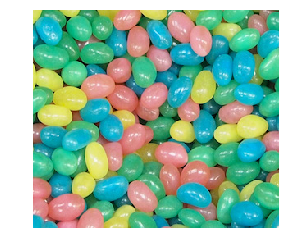

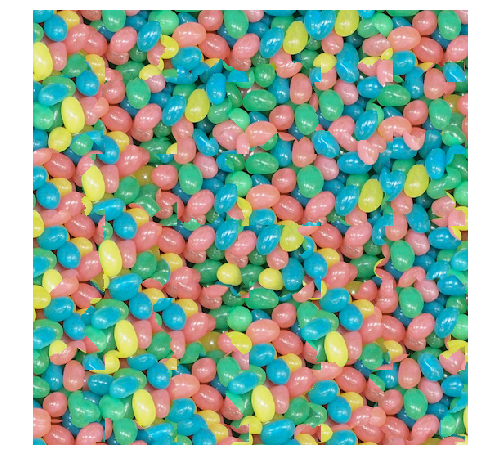

In [36]:
inp_image = './jelly_beans.jpg'
output = texture_synthesis(inp_image, factor = 2, err_threshold = 0.15 )


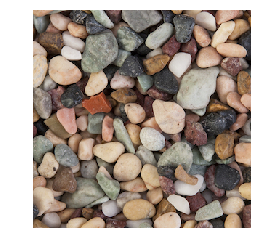

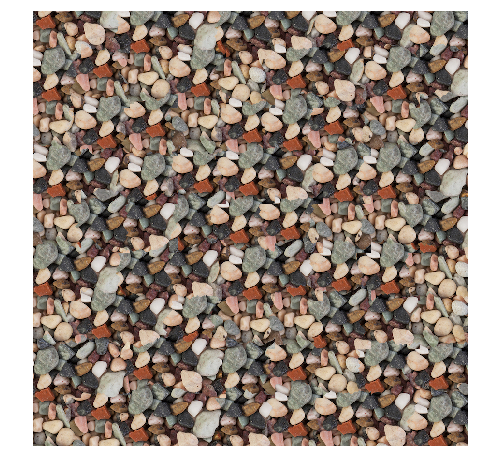

In [37]:
inp_image = './rocks.jpg'
output = texture_synthesis(inp_image, factor = 3, err_threshold = 0.10 )


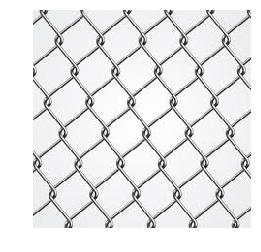

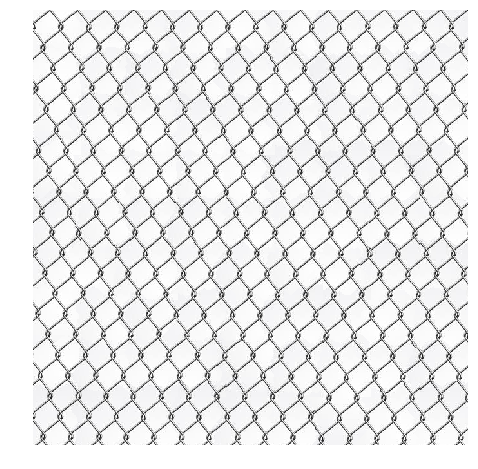

In [38]:
inp_image = './fence.jpg'
output = texture_synthesis(inp_image, factor = 3, err_threshold = 0.15 )

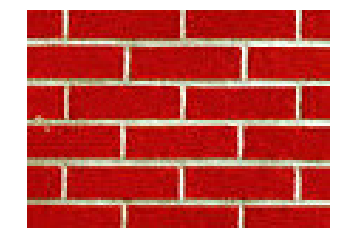

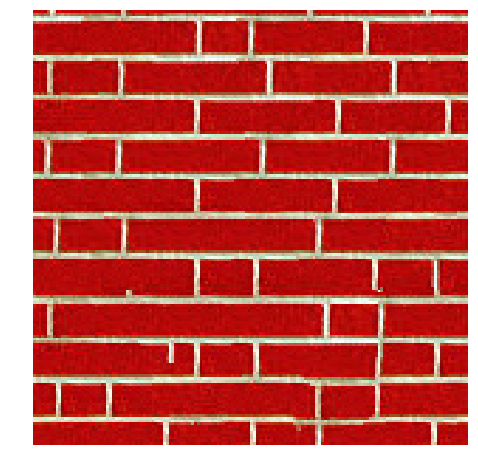

In [39]:
inp_image = './bricks.jpg'
img = np.array(Image.open(inp_image))
output = texture_synthesis(inp_image, factor = 2, err_threshold = 0.05 )

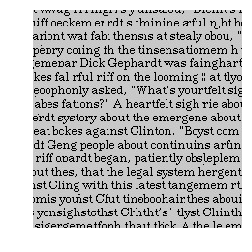

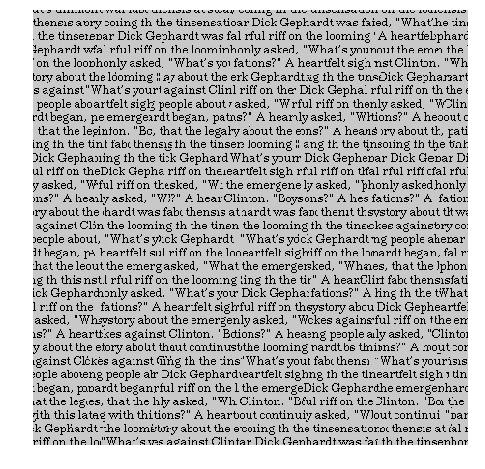

In [58]:
inp_image = 'text.jpg'
img = np.array(Image.open(inp_image))
output = texture_synthesis(inp_image, factor = 2, err_threshold = 0.05 )

In [85]:
def storeImages(location):
    images = ["rocks.jpg", "jelly_beans.jpg", "fence.jpg"]
    for img in images:
        for i in range(50):
            fact = randint(1,3)
            err_thresh = random() * 0.30
            out_img = texture_synthesis(img, factor = fact, err_threshold = err_thresh, showImages=False)
            im = Image.fromarray(np.uint8(out_img * 255))
            im = im.resize((128, 128), Image.ANTIALIAS)
            im.save("./" + location + "/" + img[:-4] + "/" + str(i)+ ".jpg")
        
    

In [ ]:
storeImages("train")

In [110]:
def loadImages(location):
    paths = ["rocks", "jelly_beans", "fence"]
    X = []
    labels = []
    for idx, dirpath in enumerate(paths):
        d = location + '/' + dirpath
        image_list = sorted(os.listdir(d))
        for img in image_list:
            img = np.array(Image.open(d + '/' + img))
            img = img.flatten()
            X.append(img)
            labels.append(idx)
    X = np.array(X)
    labels = np.array(labels)
    return X, labels

In [94]:
X, labels = loadImages("train")
pca = PCA(n_components=32)
reduced_vec = pca.fit_transform(X)

In [102]:
clf = LinearSVC(tol=1e-5)
clf.fit(X,labels)

/home/anvesh/.local/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=1e-05,
     verbose=0)

In [115]:
images = ["rocks.jpg", "jelly_beans.jpg", "fence.jpg"]
for i in range(50):
    idx = randint(0,2)
    fact = randint(1,5)
    err_thresh = random() * 0.30
    out_img = texture_synthesis(images[idx], factor = fact, err_threshold = err_thresh, showImages=False)
    im = Image.fromarray(np.uint8(out_img * 255))
    im = im.resize((128, 128), Image.ANTIALIAS)
    im.save("./test/" + images[idx][:-4] + "/" + str(i)+ ".jpg")

In [116]:
X_test, labels_test = loadImages("test")

In [117]:
reduced_test = pca.fit_transform(X_test)
y_pred = clf.predict(X_test)
target_names = ['rocks', 'jelly_beans', 'fence']
print(classification_report(labels_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       rocks       1.00      1.00      1.00        15
 jelly_beans       1.00      1.00      1.00        16
       fence       1.00      1.00      1.00        19

   micro avg       1.00      1.00      1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

